# 🏇FSAN832 Race Outcome Modeling/ Gaoxiang Chen

In [1]:
!git clone https://github.com/flyaflya/fsan830spring2025.git
%cd fsan830spring2025

Cloning into 'fsan830spring2025'...
remote: Enumerating objects: 2814, done.
remote: Counting objects: 100% (546/546), done.
remote: Compressing objects: 100% (249/249), done.
remote: Total 2814 (delta 340), reused 297 (delta 297), pack-reused 2268 (from 1)
Receiving objects: 100% (2814/2814), 52.97 MiB | 13.01 MiB/s, done.
Resolving deltas: 100% (1014/1014), done.
Updating files: 100% (710/710), done.
/content/fsan830spring2025


In [2]:
%cd fsan830spring2025

[Errno 2] No such file or directory: 'fsan830spring2025'
/content/fsan830spring2025


In [3]:
!pip install -U numpy pymc pymc-bart arviz xarray matplotlib scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 955.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 57.5 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
  Attempting uninstall: xarray
    Found existing installation: xarray 2025.3.1
    Uninstalling xarray-2025.3.1:
      Successfully uninstalled xarray-2025.3.1


In [4]:
import pymc, pymc_bart
print("pymc version:", pymc.__version__)
print("pymc-bart version:", pymc_bart.__version__)

pymc version: 5.22.0
pymc-bart version: 0.9.1


In [5]:
import pandas as pd
import numpy as np
import pymc as pm
from pymc_bart import BART
from glob import glob
import os
import xml.etree.ElementTree as ET


In [10]:
# ====== 1. Batch parse pastPerformanceData features ======
def parse_past_performance(xml_path):
    import xml.etree.ElementTree as ET
    tree = ET.parse(xml_path)
    root = tree.getroot()
    records = []
    for race in root.findall('Race'):
        race_number = race.findtext('RaceNumber')
        # Iterate over all Starters nodes
        for starters in race.findall('Starters'):
            record = {'RaceNumber': race_number}
            # Extract horse and race information
            for item in starters:
                if item.tag == 'Horse':
                    record['HorseName'] = item.findtext('HorseName')
                    record['YearOfBirth'] = item.findtext('YearOfBirth')
                    record['FoalingArea'] = item.findtext('FoalingArea')
                elif item.tag in ['PostPosition', 'ProgramNumber', 'WeightCarried', 'Odds']:
                    record[item.tag] = item.text
                elif item.tag == 'Trainer':
                    record['Trainer'] = (item.findtext('LastName') or '') + (item.findtext('FirstName') or '')
                elif item.tag == 'Jockey':
                    record['Jockey'] = (item.findtext('LastName') or '') + (item.findtext('FirstName') or '')
            # Keep record only if HorseName is valid
            if record.get('HorseName'):
                for k in record:
                    if isinstance(record[k], str):
                        record[k] = record[k].strip()
                records.append(record)
    return pd.DataFrame(records)

# ====== 2. Batch parse race result features ======
def parse_results(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    records = []
    for race in root.findall('.//RACE'):
        race_number = race.get('NUMBER')
        for entry in race.findall('ENTRY'):
            record = {
                'RaceNumber': race_number,
                'HorseName': entry.findtext('NAME'),
                'OfficialFinish': entry.findtext('OFFICIAL_FIN'),
                'FinishTime': entry.findtext('FINISH_TIME'),
                'SpeedRating': entry.findtext('SPEED_RATING'),
                'DollarOdds': entry.findtext('DOLLAR_ODDS'),
            }
            for k in record:
                if isinstance(record[k], str):
                    record[k] = record[k].strip()
            records.append(record)
    return pd.DataFrame(records)

# ====== 3. Read and merge all XML files ======
pp_dir = 'data/rawDataForTraining/pastPerformanceData'
res_dir = 'data/rawDataForTraining/resultsData'

pp_files = glob(os.path.join(pp_dir, '*.xml'))
res_files = glob(os.path.join(res_dir, '*.xml'))

print(f"Found {len(pp_files)} past performance files, {len(res_files)} result files.")

pp_dfs = [parse_past_performance(f) for f in pp_files]
res_dfs = [parse_results(f) for f in res_files]

df_feat = pd.concat(pp_dfs, ignore_index=True)
df_label = pd.concat(res_dfs, ignore_index=True)

print("Feature set shape:", df_feat.shape, "Label set shape:", df_label.shape)

# Normalize key columns for merging
for df in [df_feat, df_label]:
    df['HorseName'] = df['HorseName'].astype(str).str.lower().str.strip()
    df['RaceNumber'] = df['RaceNumber'].astype(str).str.strip()

# Merge features and labels
df_full = pd.merge(df_feat, df_label, on=['RaceNumber', 'HorseName'], how='inner', suffixes=('_pp', '_res'))
print("Merged training set shape:", df_full.shape)

# Convert odds formats (e.g., '5/2') into float
def odds_str_to_float(odds):
    if pd.isna(odds):
        return None
    try:
        return float(odds)
    except:
        if '/' in str(odds):
            try:
                num, den = odds.split('/')
                return float(num) / float(den)
            except:
                return None
        return None

# Type conversions
df_full['Odds_float'] = df_full['Odds'].apply(odds_str_to_float)
df_full['DollarOdds'] = pd.to_numeric(df_full['DollarOdds'], errors='coerce')
df_full['OfficialFinish'] = pd.to_numeric(df_full['OfficialFinish'], errors='coerce')
df_full['FinishTime'] = pd.to_numeric(df_full['FinishTime'], errors='coerce')
df_full['SpeedRating'] = pd.to_numeric(df_full['SpeedRating'], errors='coerce')
df_full['WeightCarried'] = pd.to_numeric(df_full['WeightCarried'], errors='coerce')

# Save to CSV if needed
df_full.to_csv('final_supervised_training_set.csv', index=False)
print(df_full.head())
print("Features available for modeling:", df_full.columns.tolist())


Found 18 past performance files, 18 result files.
Feature set shape: (1757, 10) Label set shape: (1482, 6)
Merged training set shape: (1509, 14)
  RaceNumber         HorseName YearOfBirth FoalingArea PostPosition  \
0          1    lady samaritan        2020          KY            2   
1          1   two minute lick        2020          KY            3   
2          1       beach walkn        2020          KY            5   
3          1   destine to race        2020          KY            6   
4          1  back to gridlock        2020          KY            8   

  ProgramNumber  WeightCarried             Trainer            Jockey  Odds  \
0             2            118  Correas, IVIgnacio  CheminaudVincent  30/1   
1             3            118    Arnold, IIGeorge    HernandezColby  20/1   
2             5            118        ColebrookBen       MachadoLuan   6/1   
3             6            118      LovellMichelle    Ortiz, Jr.Irad   4/1   
4             8            118        

In [12]:

feature_cols = ['Odds_float', 'WeightCarried', 'SpeedRating']
'''
feature_cols = [
    'YearOfBirth',
    'FoalingArea',
    'PostPosition',
    'WeightCarried',
    'Trainer',
    'Jockey',
    'SpeedRating',
    'Odds_float'
]
'''
X = df_full[feature_cols].fillna(0).values
y = df_full['OfficialFinish'].values


In [13]:

# Keep only the selected features
feature_cols = ['Odds_float', 'WeightCarried', 'SpeedRating']


column_indices = [
    515,  # Odds
    50,   # WeightCarried
    845   # SpeedRating
]


columns = ['Odds', 'WeightCarried', 'SpeedRating']


X_test = pd.read_csv('data/rawDataForPrediction/CDX0426.csv', header=None, usecols=column_indices)
X_test.columns = columns


def odds_str_to_float(s):
    try:
        if pd.isna(s):
            return None
        if '-' in str(s):
            a, b = str(s).split('-')
            return float(a) / float(b)
        return float(s)
    except:
        return None

X_test['Odds_float'] = X_test['Odds'].apply(odds_str_to_float)

# Keep only feature_cols
X_test_final = X_test[feature_cols]

print(X_test_final)

    Odds_float  WeightCarried  SpeedRating
0        118.0          17.21         81.0
1        118.0          14.10         73.0
2        118.0          33.57         57.0
3        118.0          49.95         64.0
4        113.0           8.45         79.0
..         ...            ...          ...
89       118.0           6.71         76.0
90       118.0           9.60         76.0
91       118.0          10.87         79.0
92       118.0         104.12         80.0
93       113.0           1.70         64.0

[94 rows x 3 columns]


In [14]:

with pm.Model() as model:
    μ = BART("μ", X, y)
    σ = pm.HalfNormal("σ", sigma=1.0)
    y_obs = pm.Normal("y_obs", mu=μ, sigma=σ, observed=y)
    trace = pm.sample(1000, tune=1000, target_accept=0.95, cores=1, random_seed=42)
    print("Model training complete！")


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Model training complete！


In [15]:
import pymc as pm
from pymc_bart import BART
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from datetime import datetime

# --------------------------
# 1. Prepare training data
# --------------------------
X_train = df_full[feature_cols].fillna(0).values
y_train = df_full['OfficialFinish'].values

# --------------------------
# 2. Train BART model
# --------------------------
with pm.Model() as model:
    μ = BART("μ", X_train, y_train)
    σ = pm.HalfNormal("σ", sigma=1.0)
    y_obs = pm.Normal("y_obs", mu=μ, sigma=σ, observed=y_train)

    trace = pm.sample(
        1000,
        tune=1000,
        target_accept=0.95,
        cores=1,
        random_seed=42,
        idata_kwargs={"log_likelihood": True}  # ✅ Ensure μ is recorded into trace
    )

print("✅ Model training complete！")


Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


✅ Model training complete！


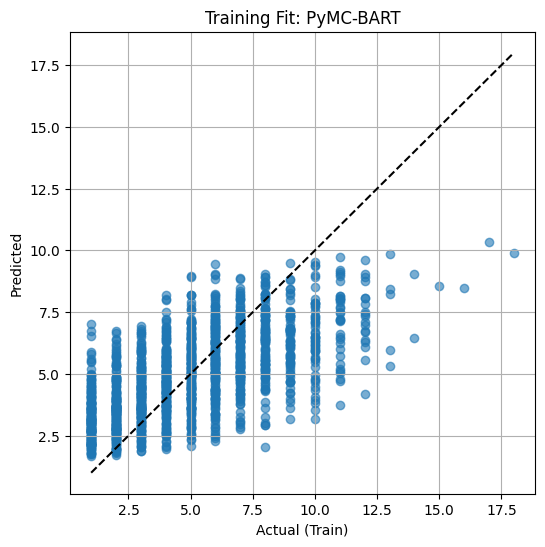

Training set R² Score: 0.4204
Training set RMSE: 2.22


In [16]:
# Extract posterior mean of μ from trace.posterior
μ_train_mean = trace.posterior["μ"].mean(dim=("chain", "draw")).values

# Visualize training fit
plt.figure(figsize=(6, 6))
plt.scatter(y_train, μ_train_mean, alpha=0.6)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--')
plt.xlabel("Actual (Train)")
plt.ylabel("Predicted")
plt.title("Training Fit: PyMC-BART")
plt.grid(True)
plt.show()

# Model performance metrics（Training set）
r2 = r2_score(y_train, μ_train_mean)
rmse = np.sqrt(mean_squared_error(y_train, μ_train_mean))
print(f"Training set R² Score: {r2:.4f}")
print(f"Training set RMSE: {rmse:.2f}")


In [17]:
from datetime import datetime

def bart_train_and_predict(df_train, df_test_raw, feature_cols, target_col):

    X_train = df_train[feature_cols].fillna(0).values
    y_train = df_train[target_col].values

    X_test = df_test_raw[feature_cols].fillna(0).values
    n_test = X_test.shape[0]


    X_all = np.vstack([X_train, X_test])
    y_all = np.concatenate([y_train, np.zeros(n_test)])


    with pm.Model() as model:
        μ_all = BART("μ", X_all, y_all)
        σ = pm.HalfNormal("σ", sigma=1.0)


        y_obs = pm.Normal("y_obs", mu=μ_all[:len(y_train)], sigma=σ, observed=y_train)

        y_pred = pm.Normal("y_pred", mu=μ_all[len(y_train):], sigma=σ)

        trace = pm.sample(
            1000, tune=1000, target_accept=0.95, cores=1, random_seed=42
        )


        ppc = pm.sample_posterior_predictive(
            trace, var_names=["y_pred"], return_inferencedata=False
        )


    y_pred_dist = ppc["y_pred"]  # shape: (n_chains, n_draws, n_test)
    y_pred_dist = y_pred_dist.reshape(-1, y_pred_dist.shape[-1])  # => (n_samples_total, n_test)

    if y_pred_dist.shape[1] != n_test:
        raise ValueError("[translated]")

    y_pred_mean = y_pred_dist.mean(axis=0)
    y_pred_std = y_pred_dist.std(axis=0)


    results_df = df_test_raw.reset_index(drop=True).copy()
    results_df["PredictedFinish"] = y_pred_mean
    results_df["PredictedStd"] = y_pred_std
    results_df["PredictedRank"] = results_df["PredictedFinish"].rank(method="min").astype(int)

    return results_df.sort_values("PredictedFinish").reset_index(drop=True)

In [18]:

feature_cols = ['Odds_float', 'WeightCarried', 'SpeedRating']
target_col = 'OfficialFinish'

# Train and predict
results_df_sorted = bart_train_and_predict(df_full, X_test, feature_cols, target_col)

# Print top predictions
print("Prediction finished at：", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print(results_df_sorted.head(10))




Output()

Output()

Prediction finished at： 2025-05-23 01:36:57
   Odds  WeightCarried  SpeedRating  Odds_float  PredictedFinish  \
0   118           1.00         93.0       118.0         6.126705   
1   123          18.20         93.0       123.0         6.131218   
2   125          17.48         86.0       125.0         6.279463   
3   123           6.10         88.0       123.0         6.333259   
4   124           0.63         90.0       124.0         6.439195   
5   118           4.80         88.0       118.0         6.481351   
6   125           1.71         86.0       125.0         6.526072   
7   118           1.90         91.0       118.0         6.570346   
8   124           6.00         86.0       124.0         6.592524   
9   125          11.20         83.0       125.0         6.672862   

   PredictedStd  PredictedRank  
0      2.310409              1  
1      2.310812              2  
2      2.320946              3  
3      2.325087              4  
4      2.301239              5  
5      2.

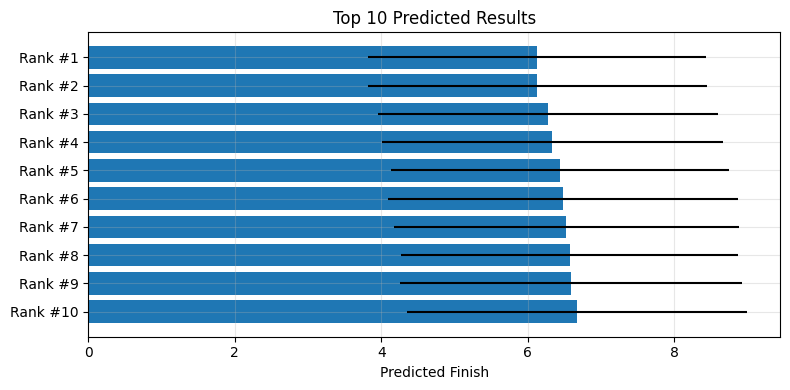

In [21]:

top10 = results_df_sorted.head(10).copy()
top10_labels = [f"Rank #{i+1}" for i in range(len(top10))]

plt.figure(figsize=(8, 4))
plt.barh(top10_labels, top10["PredictedFinish"], xerr=top10["PredictedStd"])
plt.xlabel("Predicted Finish")
plt.title("Top 10 Predicted Results")
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
